In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,f1_score
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import joblib

# Load extracted MFCC features
data = np.load('cnn_features_augmented.npz', allow_pickle=True)
X, y = data['data'], data['labels']

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_onehot = to_categorical(y_encoded)
joblib.dump(le, "label_encoder.pkl")

# Normalize and reshape
X = X[..., np.newaxis]  
X = X / np.max(X)       

# Train/Val split
X_train, X_val, y_train, y_val = train_test_split(
    X, y_onehot, test_size=0.2, stratify=y_encoded, random_state=42
)
y_train_encoded = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded),
    y=y_encoded
)
class_weight_dict = dict(enumerate(class_weights))
# CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(40, 130, 1)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='softmax')  
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', patience=2, factor=0.5,verbose=1)


# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=32, batch_size=32,callbacks=[early_stop, lr_reduce],class_weight=class_weight_dict)

# Save model
model.save("cnn_emotion_model.h5")

# Evaluate
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"\nCNN Validation Accuracy: {val_acc:.4f}")


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 38, 128, 32)       320       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 19, 64, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_9 (Bat  (None, 19, 64, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_10 (Conv2D)          (None, 17, 62, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 8, 31, 64)         0         
 ng2D)                                                           
                                                      

C:\Users\lenovo 6pin\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


62/62 [==============================] - 1s 18ms/step - loss: 0.5065 - accuracy: 0.8767

CNN Validation Accuracy: 0.8767


NameError: name 'f1_score' is not defined

In [11]:
# Predictions
y_pred = model.predict(X_val)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)


f1 = f1_score(y_true, y_pred_labels, average='weighted')
print(f"Weighted F1 Score on Validation Set: {f1:.4f}")
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"\nCNN Validation Accuracy: {val_acc:.4f}")




62/62 [==============================] - 2s 25ms/step
Weighted F1 Score on Validation Set: 0.8760
62/62 [==============================] - 1s 19ms/step - loss: 0.5065 - accuracy: 0.8767

CNN Validation Accuracy: 0.8767


y_pred_labels shape: (1962,)
y_true shape: (1962,)

Classification Report:

              precision    recall  f1-score   support

       angry       0.89      0.95      0.92       301
        calm       0.87      0.93      0.90       301
     disgust       0.87      0.87      0.87       154
     fearful       0.86      0.81      0.83       301
       happy       0.90      0.89      0.90       301
     neutral       0.88      0.85      0.87       150
         sad       0.83      0.80      0.82       301
   surprised       0.93      0.90      0.91       153

    accuracy                           0.88      1962
   macro avg       0.88      0.88      0.88      1962
weighted avg       0.88      0.88      0.88      1962



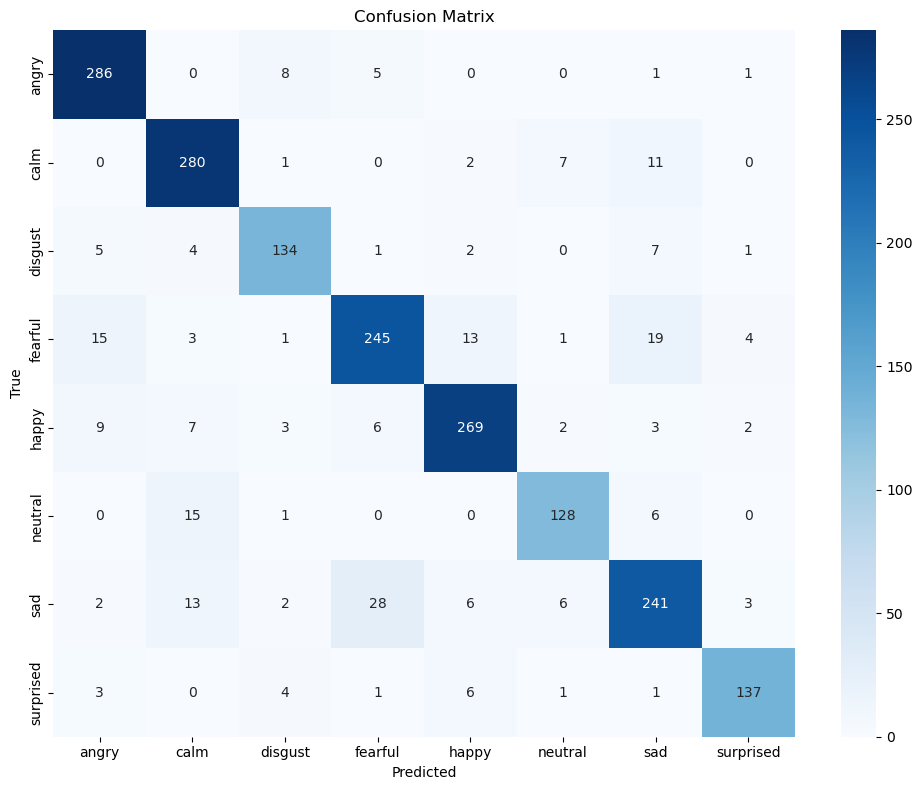

In [12]:

# Print shapes to verify
print("y_pred_labels shape:", y_pred_labels.shape)  # (491,)
print("y_true shape:", y_true.shape)                # (491,)


# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_labels, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig("confusion_matrix_cnn.png")
plt.show()

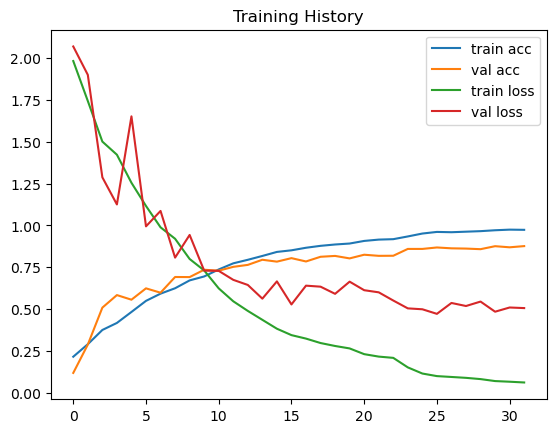

In [7]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Training History')
plt.show()
